To open on Google Colab [link](https://colab.research.google.com/github/RodrigoAVargasHdz/CHEM-4PB3/blob/main/Course_Notes/Week9/molecular_fingerprints.ipynb)

In [10]:
# !pip3 install cairosvg
# !pip install rdkit-pypi
# !pip install avogadro
# !pip install py3Dmol

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdMolDescriptors, rdDistGeom, rdMolTransforms, QED
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem.Draw import IPythonConsole

import networkx as nx

IPythonConsole.ipython_useSVG = True
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300

## ChemInformatics

*Molecular descriptors capture diverse parts of the structural information of molecules and they are the support of many contemporary computer-assisted toxicological and chemical applications.*

Being able to numerically represent molecules aid with the prediction problem,
$$
y = f(\mathbf{{\cal M}}),
$$
where $\mathbf{{\cal M}}$ is the molecular descriptors used in regression/classification.

<img src="https://raw.github.com/RodrigoAVargasHdz/CHEM-4PB3/master/Course_Notes/Figures/440801_1_En_1_Fig1_HTML.png"  width="500" height="700">

Figure from [link](https://link.springer.com/protocol/10.1007/978-1-4939-7899-1_1)


Molecular descriptors can describe different levels of information, from bulk properties to complex three-dimensional definitions or substructure frequency.
1. **0-Dimensional**:\
   atom counts (e.g., number of carbon atoms), molecular weight, and sum or average of atomic properties (e.g., atomic van der Waals volumes).
2. **1-Dimensional**:\
   molecules are perceived as a set of substructures, such as functional groups or atom-centered fragments.
3. **2-Dimensional**:\
   molecule is represented as a graph, whose vertexes are the atoms and edges are the bonds, and specific chemical properties of atoms are considered.
4. **3-Dimensional**:\
   descriptors deriving from 3D representation.
5. **4-Dimensional**:\
   molecular geometry combined with an “additional dimension/information”, e.g., representing each ligand by an ensemble of conformations, protonation states, and/or orientations.


## Classical molecular descriptors and binary fingerprints


**Classical molecular descriptors** (MDs) are designed to encode a precise structural/chemical feature (or a set of features of different complexity) into one, single number. 
They can also be combined with other molecular properties that could be efficiently estimated. 

**RDKit molecular descriptors** ([list](https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html?highlight=calcnumhba#rdkit.Chem.rdMolDescriptors.CalcNumHBA))


['CN1C=NC2=C1C(=O)N(C(=O)N2C)C']
(30, 35)


([<matplotlib.axis.YTick at 0x122d38c10>,
 [Text(0, 0, '7'),
  Text(0, 1, '6'),
  Text(0, 2, 'o'),
  Text(0, 3, ']'),
  Text(0, 4, '3'),
  Text(0, 5, 's'),
  Text(0, 6, '('),
  Text(0, 7, '-'),
  Text(0, 8, 'S'),
  Text(0, 9, '/'),
  Text(0, 10, 'B'),
  Text(0, 11, '4'),
  Text(0, 12, '['),
  Text(0, 13, ')'),
  Text(0, 14, '#'),
  Text(0, 15, 'I'),
  Text(0, 16, 'l'),
  Text(0, 17, 'O'),
  Text(0, 18, 'H'),
  Text(0, 19, 'c'),
  Text(0, 20, '1'),
  Text(0, 21, '@'),
  Text(0, 22, '='),
  Text(0, 23, 'n'),
  Text(0, 24, 'P'),
  Text(0, 25, '8'),
  Text(0, 26, 'C'),
  Text(0, 27, '2'),
  Text(0, 28, 'F'),
  Text(0, 29, '5'),
  Text(0, 30, 'r'),
  Text(0, 31, 'N'),
  Text(0, 32, '+'),
  Text(0, 33, '\\'),
  Text(0, 34, ' ')])

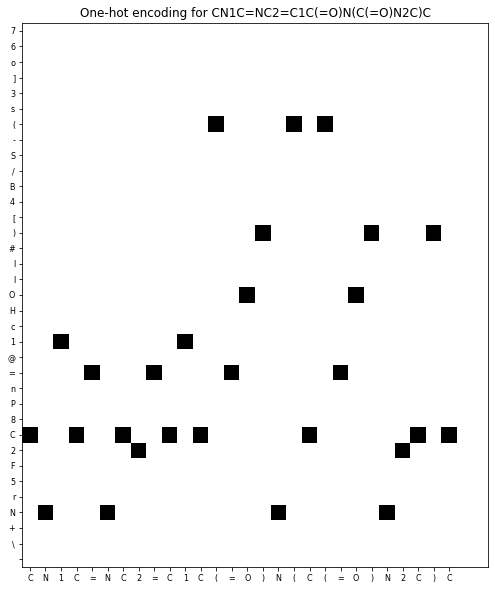

In [12]:
# one-hot-encoding
# ALPHABET: define SMILES characters

max_len = 30
SMILES_CHARS = ["7", "6", "o", "]", "3", "s", "(", "-", "S", "/", "B", "4", "[", ")", "#", "I",
                "l", "O", "H", "c", "1", "@", "=", "n", "P", "8", "C", "2", "F", "5", "r", "N", "+", "\\", " "]
# index
smi2index = dict((c, i) for i, c in enumerate(SMILES_CHARS))


def smiles_to_one_hot(smiles, maxlen=max_len):
    X = np.zeros((maxlen, len(SMILES_CHARS)))  # (maxlen, dictionary)
    # print(smiles,type(smiles))
    smiles = smiles.replace('\n', '')
    for i, c in enumerate(smiles):
        X[i, smi2index[c]] = 1
    return X


# caffeine one hot
caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
print(caffeine_smiles.split())

caffeine_one_hot = smiles_to_one_hot(caffeine_smiles)

print(caffeine_one_hot.shape)  # (120, 56)


plt.figure(figsize=(10, 10))
plt.imshow(caffeine_one_hot.T, cmap='binary')
# plt.xlabel('Tokens')
# plt.ylabel('SMILES')


caffeine_smiles_pad = caffeine_smiles + " " * (max_len - len(caffeine_smiles))

plt.title('One-hot encoding for %s' % caffeine_smiles)
plt.xticks(np.arange(len(list(caffeine_smiles))),
           list(caffeine_smiles), fontsize=8)
plt.yticks(np.arange(len(list(SMILES_CHARS))),
           list(SMILES_CHARS), fontsize=8)


In [13]:
def get_classical_md(m):
    canon_smiles = AllChem.MolToSmiles(m, canonical=True)
    # number of H-bond acceptors for a molecule
    hba = rdMolDescriptors.CalcNumHBA(m)

    # number of H-bond donors for a molecule
    hbd = rdMolDescriptors.CalcNumHBD(m)

    # number of rings for a molecule
    nrings = rdMolDescriptors.CalcNumRings(m)

    # number of rotatable bonds for a molecule
    rtb = rdMolDescriptors.CalcNumRotatableBonds(m)

    #  topological polar surface area (TPSA) of a molecule (used medicinal chemistry metric for the optimization of a drug's ability to permeate cells.)
    psa = rdMolDescriptors.CalcTPSA(m)

    # logP and mr from https://pubs.acs.org/doi/10.1021/ci990307l:
    # logP ->  water partition coefficient as measure of lipophilicity
    # MR -> molar refractivity
    logp, mr = rdMolDescriptors.CalcCrippenDescriptors(m)

    # molecular weight
    mw = rdMolDescriptors._CalcMolWt(m)

    # Csp3: fraction of sp3 carbons
    csp3 = rdMolDescriptors.CalcFractionCSP3(m)
    
    # fraction of atoms belonging to Murcko framework
    # number of heavy atoms for a molecule
    fmf = GetScaffoldForMol(m).GetNumHeavyAtoms() / m.GetNumHeavyAtoms()
    hac = m.GetNumHeavyAtoms()

    # max_ring_size: maximum ring size in a molecule
    max_ring_size = len(max(m.GetRingInfo().AtomRings(), key=len, default=()))

    # QED: quantitative estimate of drug-likeness (https://www.rdkit.org/docs/source/rdkit.Chem.QED.html)
    qed = QED.qed(m)
    
    # ChiralCenters: number of chiral centers (assigned and unassigned)
    n_chiral_centers = len(Chem.FindMolChiralCenters(m, includeUnassigned=True))
    
    # plane of best fit (PBF), to quantify and characterize the 3D character of molecules (https://pubs.acs.org/doi/pdf/10.1021/ci300293f)
#     pbf = 
    
    r = {'Canonical SMILE': canon_smiles,
         'HBA': hba,
         'HBD': hbd,
         'NumRings': nrings,
         'RTB': rtb,
         'lopP': logp,
         'MR': mr,
         'MW': mw,
         'Csp3': csp3,
         'fmf': fmf,
         'QED': qed,
         'HAC': hac,
         'ChiralCenters': n_chiral_centers,
         'MaxRingSize':max_ring_size,
    }
    return r


{'Canonical SMILE': 'CCCO', 'HBA': 1, 'HBD': 1, 'NumRings': 0, 'RTB': 1, 'lopP': 0.3887, 'MR': 17.3768, 'MW': 60.096000000000004, 'Csp3': 1.0, 'fmf': 0.0, 'QED': 0.46378398302396845, 'HAC': 4, 'ChiralCenters': 0, 'MaxRingSize': 0}


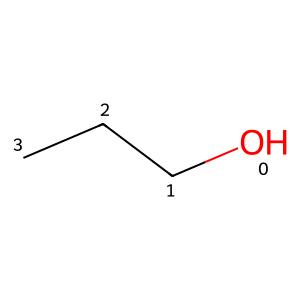

In [14]:
# m = "O=C(Oc1cccnc1)c1cccs1"
m = 'OCCC'
mol = AllChem.MolFromSmiles(m)
print(get_classical_md(mol))
mol

In [15]:
import pandas as pd

url = 'https://raw.github.com/sp8rks/MaterialsInformatics/master/worked_examples/RDKit_tutorial/full_dataset_dd.csv'

data = pd.read_csv(url, index_col=0)

smiles_all = data['SMILES_STD']
print('Total number of molecules: ', len(smiles_all))


D = {}
for i,smi in enumerate(smiles_all):
    m = AllChem.MolFromSmiles(smi)
    r = get_classical_md(m)
    D.update({i:r})
print(D)
data = pd.DataFrame.from_dict(D,orient='index')
data.head()

Total number of molecules:  663
{0: {'Canonical SMILE': 'Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21', 'HBA': 5, 'HBD': 0, 'NumRings': 3, 'RTB': 2, 'lopP': 1.89262, 'MR': 72.65450000000003, 'MW': 281.271, 'Csp3': 0.2, 'fmf': 0.8095238095238095, 'QED': 0.7843287546239021, 'HAC': 21, 'ChiralCenters': 0, 'MaxRingSize': 6}, 1: {'Canonical SMILE': 'O=C1C(=O)N(Cc2ccc(C(=O)N3CCCCC3)s2)c2ccc(I)cc21', 'HBA': 4, 'HBD': 0, 'NumRings': 4, 'RTB': 3, 'lopP': 3.708300000000003, 'MR': 108.75300000000003, 'MW': 480.327, 'Csp3': 0.3157894736842105, 'fmf': 0.9615384615384616, 'QED': 0.4975247606096907, 'HAC': 26, 'ChiralCenters': 0, 'MaxRingSize': 6}, 2: {'Canonical SMILE': 'CC(C)c1cc2c(cc1O)[C@@]1(C)CCCC(C)(C)[C@@H]1CC2', 'HBA': 1, 'HBD': 1, 'NumRings': 3, 'RTB': 1, 'lopP': 5.545800000000005, 'MR': 88.99080000000005, 'MW': 286.459, 'Csp3': 0.7, 'fmf': 0.6666666666666666, 'QED': 0.7177106819779207, 'HAC': 21, 'ChiralCenters': 2, 'MaxRingSize': 6}, 3: {'Canonical SMILE': 'COc1ccc(-c2cc(=O)c3c(O)cc(O)c(-c4cc(-c

,Canonical SMILE,HBA,HBD,NumRings,RTB,lopP,MR,MW,Csp3,fmf,QED,HAC,ChiralCenters,MaxRingSize
0,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,5,0,3,2,1.89262,72.6545,281.271,0.200000,0.809524,0.784329,21,0,6
1,O=C1C(=O)N(Cc2ccc(C(=O)N3CCCCC3)s2)c2ccc(I)cc21,4,0,4,3,3.70830,108.7530,480.327,0.315789,0.961538,0.497525,26,0,6
2,CC(C)c1cc2c(cc1O)[C@@]1(C)CCCC(C)(C)[C@@H]1CC2,1,1,3,1,5.54580,88.9908,286.459,0.700000,0.666667,0.717711,21,2,6
3,COc1ccc(-c2cc(=O)c3c(O)cc(O)c(-c4cc(-c5cc(=O)c...,10,3,6,6,6.04300,159.4844,580.545,0.090909,0.790698,0.212744,43,0,6
4,COc1ccc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc1-c1c(O)cc...,10,5,6,4,5.43700,149.7100,552.491,0.032258,0.829268,0.189724,41,0,6


14 Index(['Canonical SMILE', 'HBA', 'HBD', 'NumRings', 'RTB', 'lopP', 'MR', 'MW',
       'Csp3', 'fmf', 'QED', 'HAC', 'ChiralCenters', 'MaxRingSize'],
      dtype='object')


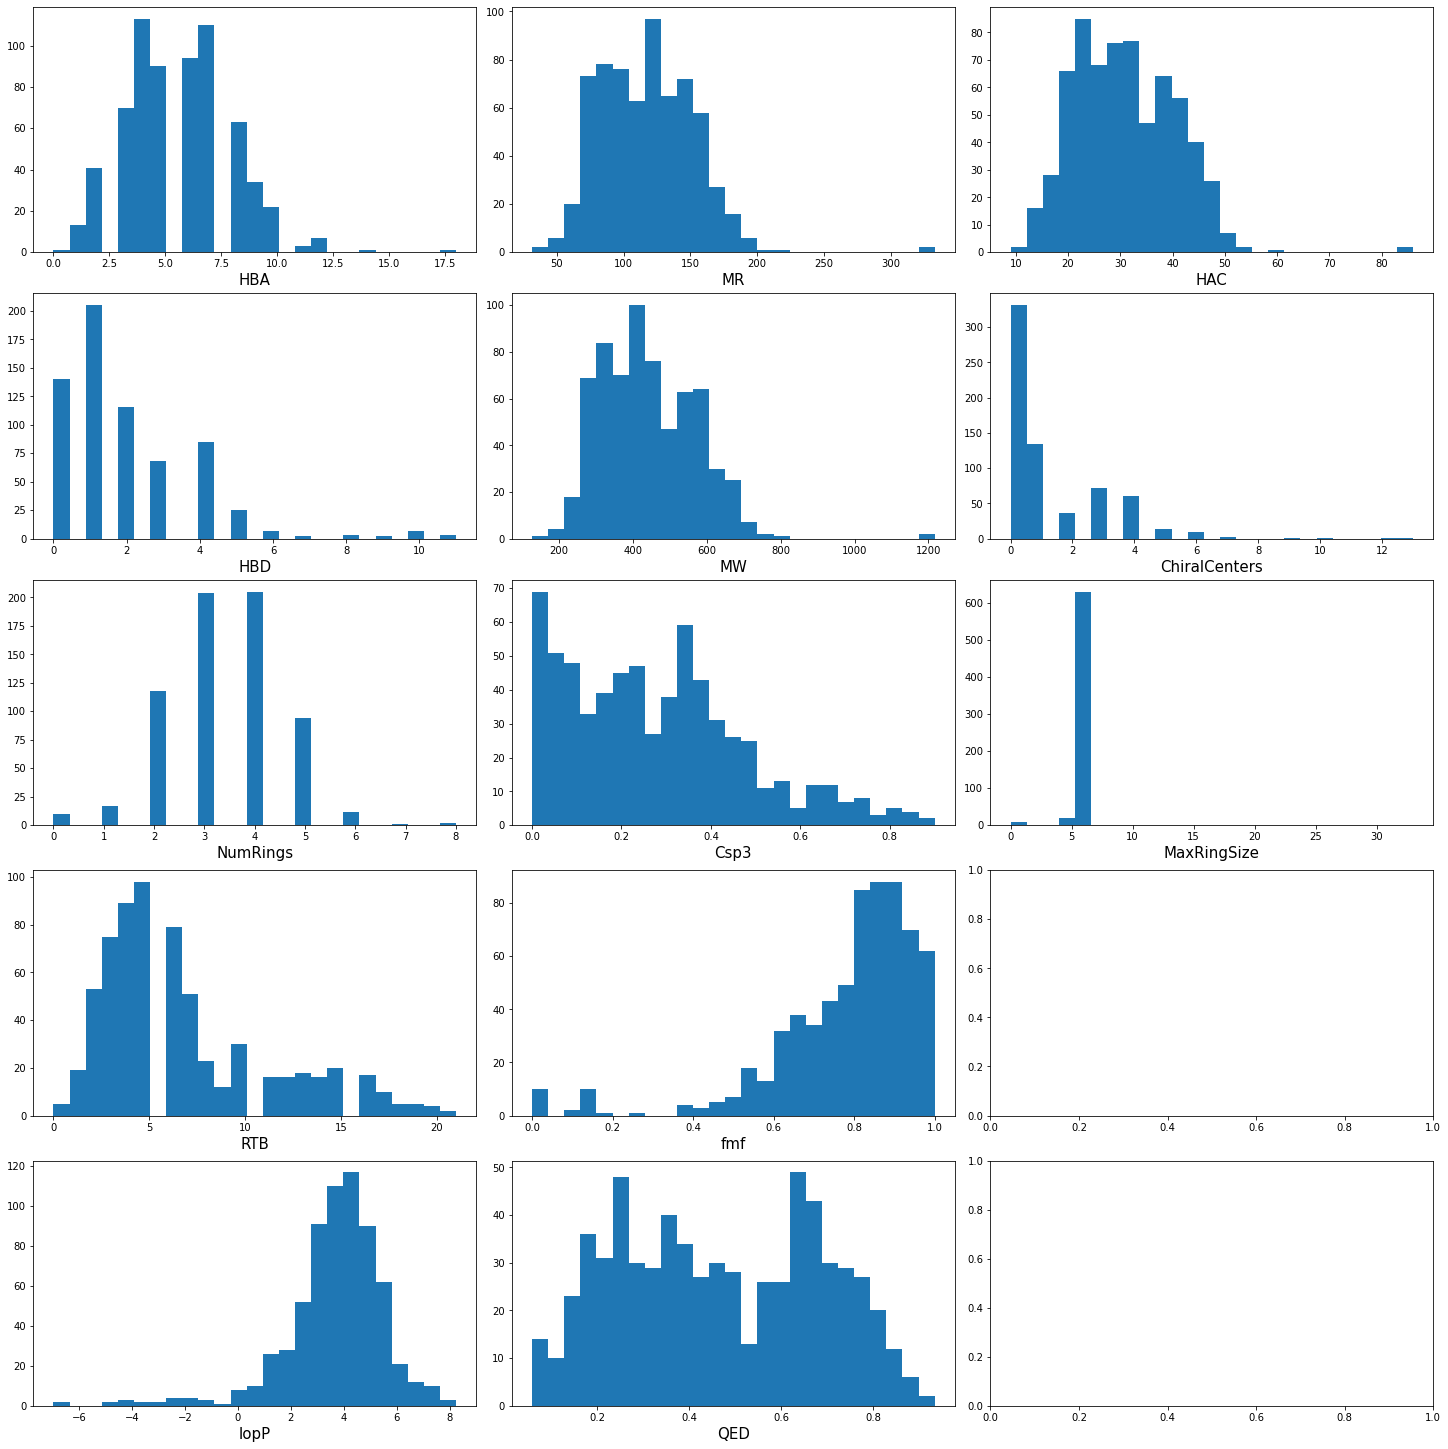

In [16]:
cols = data.columns
ncols = len(cols)
print(ncols,cols)

fig = plt.figure(layout="constrained",figsize=(20,20))
axs = fig.subplots(nrows=5,ncols=3,squeeze=False)
ni_,nj_ = np.meshgrid(np.arange(0,5,dtype=np.int32),np.arange(0,3,dtype=np.int32)) 
nij = np.column_stack((ni_.flatten(),nj_.flatten()))

for i,(ij,ci) in enumerate(zip(nij,cols[1:])):
    r = data[ci].to_numpy()
    axs[ij[0],ij[1]].hist(r,bins=25)
    axs[ij[0], ij[1]].set_xlabel(cols[i+1],fontsize=15)
plt.show()

## 1D and 2D molecular finger prints

1. **1-Dimensional**:\
   molecules are perceived as a set of substructures, such as functional groups or atom-centered fragments.
2. **2-Dimensional**:\
   molecule is represented as a graph, whose vertexes are the atoms and edges are the bonds, and specific chemical properties of atoms are considered.

 
### Molecular/Circular Fingerprints aka Morgan Fingerprints ([paper](https://pubs.acs.org/doi/10.1021/ci100050t))



* topological fingerprints for molecular characterization.
* capture molecular features relevant to molecular activity.
* used in drug activity.
* Given a *radius*, we characterize what atom is connected/surrounded to a set of "candidates".

**Problem**\
They are non-reversible, meaning given some fingerprints we can't infer the original molecule.\
People have attempted to use deep-learning for this problem.

Papers:
1. [data-driven molecular descriptors](https://pubs.rsc.org/en/content/articlelanding/2019/sc/c8sc04175j)
2. [Neuraldecipher](https://pubs.rsc.org/en/content/articlelanding/2020/sc/d0sc03115a)


Code below is based on [link](https://rdkit.blogspot.com/2018/10/using-new-fingerprint-bit-rendering-code.html)

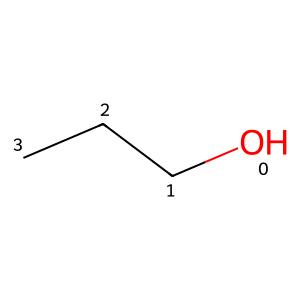

In [17]:
# m = "O=C(Oc1cccnc1)c1cccs1"
m = 'OCCC'
mol = AllChem.MolFromSmiles(m)
mol

{80: ((1, 0), (2, 0)), 222: ((0, 1),), 294: ((3, 1),), 473: ((1, 1),), 794: ((2, 1),), 807: ((0, 0),), 1057: ((3, 0),)}


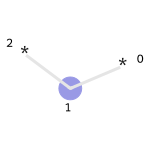

In [18]:
# fp = AllChem.GetMorganFingerprintAsBitVect(mol,3, nBits=2048)
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
    mol, radius=1, bitInfo=bi)
print(bi)
fp_indx = np.nonzero(np.array(fp))[0]

Draw.DrawMorganBit(mol, fp_indx[0], bi)

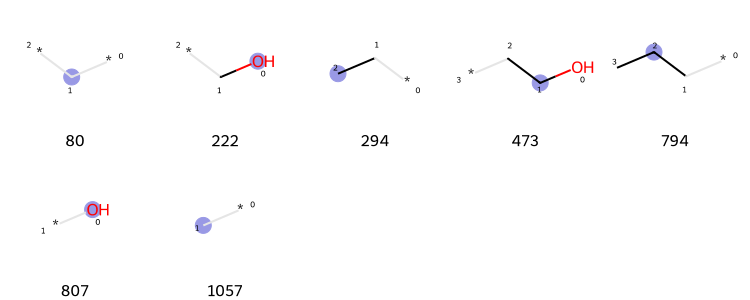

In [19]:
prints = [(mol,x,bi)for x in fp.GetOnBits()]
Draw.DrawMorganBits(prints, molsPerRow=5, legends=[str(x) for x in fp.GetOnBits()])

In [20]:
def get_fingerprints(m_smiles, radius=2, nbits=2048):
  m = Chem.MolFromSmiles(m_smiles)
  m = Chem.AddHs(m)
  m_fingerprints = AllChem.GetMorganFingerprintAsBitVect(
      m, radius=radius, nBits=nbits)
  return np.asarray(m_fingerprints)

[0 0 0 ... 0 0 0]


Text(0, 0.5, 'Binary')

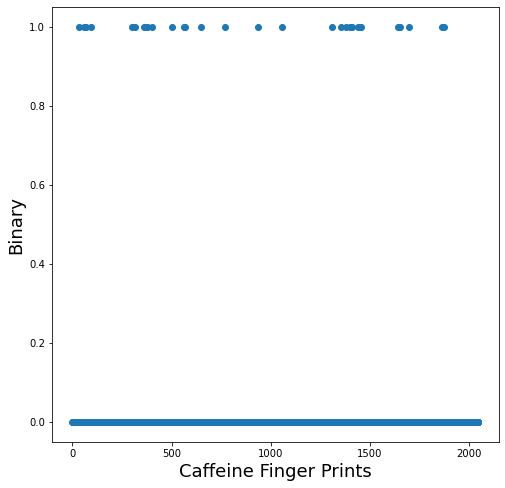

In [21]:
caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
m = AllChem.MolFromSmiles(caffeine_smiles)
r = get_fingerprints(caffeine_smiles)
print(r)

# plt.imshow(r[np.newaxis,:],)
plt.figure(figsize=(8,8))
plt.scatter(np.arange(r.shape[0]),r)
plt.xlabel('Caffeine Finger Prints',fontsize=18)
plt.ylabel('Binary',fontsize=18)

In [22]:
D = {}
for i, smi in enumerate(smiles_all):
    # m = AllChem.MolFromSmiles(smi)
    r = get_fingerprints(smi)
    D.update({i: r})

data = pd.DataFrame.from_dict(D, orient='index')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
cols = data.columns
ncols = len(cols)

print('List of FingerPrints that appear in our data set:')
count_fp = []
for i in range(ncols):
    r = data[cols[i]].to_numpy()
    nonzeros_ = np.nonzero(r)[0]
    count_fp.append(nonzeros_.shape[0])
    if nonzeros_.shape[0] > 0:
        print(f'FP-%s : %s' % (cols[i], nonzeros_.shape[0]))

count_fp = np.asarray(count_fp)
i0 = np.argsort(count_fp)[-10:]
print('Top 10 FingerPrints: ', i0)
print(count_fp[i0])


List of FingerPrints that appear in our data set:
FP-0 : 104
FP-1 : 288
FP-2 : 4
FP-3 : 26
FP-4 : 1
FP-5 : 36
FP-6 : 2
FP-7 : 1
FP-8 : 4
FP-9 : 9
FP-10 : 5
FP-11 : 8
FP-13 : 9
FP-14 : 1
FP-15 : 2
FP-16 : 2
FP-17 : 6
FP-18 : 7
FP-20 : 1
FP-22 : 2
FP-24 : 14
FP-26 : 9
FP-28 : 15
FP-30 : 29
FP-32 : 7
FP-35 : 5
FP-36 : 1
FP-38 : 24
FP-39 : 48
FP-40 : 1
FP-41 : 78
FP-42 : 6
FP-43 : 4
FP-44 : 7
FP-45 : 62
FP-46 : 1
FP-47 : 1
FP-48 : 16
FP-49 : 251
FP-50 : 10
FP-51 : 7
FP-52 : 2
FP-53 : 41
FP-54 : 15
FP-55 : 4
FP-56 : 1
FP-57 : 2
FP-58 : 8
FP-59 : 1
FP-60 : 16
FP-62 : 34
FP-63 : 15
FP-64 : 11
FP-65 : 1
FP-66 : 32
FP-67 : 9
FP-68 : 3
FP-69 : 10
FP-71 : 16
FP-72 : 2
FP-73 : 4
FP-74 : 1
FP-75 : 3
FP-77 : 1
FP-79 : 4
FP-80 : 440
FP-81 : 15
FP-82 : 8
FP-83 : 4
FP-84 : 14
FP-85 : 6
FP-86 : 1
FP-87 : 108
FP-88 : 1
FP-89 : 28
FP-91 : 477
FP-92 : 11
FP-93 : 10
FP-94 : 2
FP-95 : 9
FP-96 : 11
FP-97 : 5
FP-98 : 39
FP-99 : 171
FP-100 : 4
FP-102 : 9
FP-104 : 1
FP-105 : 1
FP-106 : 13
FP-107 : 1
FP-108 : 2
F

CC(C)c1cc2c(cc1O)[C@@]1(C)CCCC(C)(C)[C@@H]1CC2
{1: ((1, 0),), 237: ((3, 1),), 283: ((0, 1), (2, 1)), 478: ((18, 1),), 598: ((1, 1),), 807: ((9, 0),), 875: ((4, 1), (7, 1)), 926: ((12, 0), (13, 0), (14, 0), (19, 0), (20, 0)), 1019: ((18, 0),), 1028: ((13, 1),), 1057: ((0, 0), (2, 0), (11, 0), (16, 0), (17, 0)), 1060: ((10, 0), (15, 0)), 1162: ((12, 1), (14, 1)), 1232: ((15, 1),), 1236: ((5, 1),), 1274: ((11, 1), (16, 1), (17, 1)), 1325: ((19, 1),), 1380: ((3, 0), (5, 0), (6, 0), (8, 0)), 1602: ((9, 1),), 1607: ((8, 1),), 1738: ((20, 1),), 1873: ((4, 0), (7, 0)), 1884: ((10, 1),), 1980: ((6, 1),)}


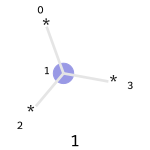

In [24]:
# What is FP-1?

smi = smiles_all[2]
print(smi)
mol = AllChem.MolFromSmiles(smi)

bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
    mol, radius=1, bitInfo=bi)
fp_indx = np.nonzero(np.array(fp))[0]
print(bi)
Draw.DrawMorganBit(mol, fp_indx[0], bi, legend=str(fp_indx[0]))


CC(=O)NCc1cccc(CNC(=O)C2CCN([C@H](C)c3cccc4ccccc34)CC2)c1


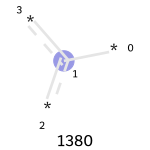

In [25]:
# What is FP-1380?

# print(data[1380])
smi = smiles_all[662]
print(smi)
mol = AllChem.MolFromSmiles(smi)

bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
    mol, radius=1, bitInfo=bi)
fp_indx = np.nonzero(np.array(fp))[0]
# print(bi)

i0 = np.where(fp_indx == 1380)[0][0]
Draw.DrawMorganBit(mol, fp_indx[i0], bi, legend=str(fp_indx[i0]))


# Conformer search with RDKit

In [26]:
def get_xyz_coordinates(m_rdkit):
    xyz = Chem.MolToMolBlock(m_rdkit) # Generates a 3D conformer
    n_atoms = m_rdkit.GetNumAtoms() # total numbers of atoms

    xyz_ = []
    for l in xyz.splitlines()[4:4+m_rdkit.GetNumAtoms()]:
        l = l.split()
        xyz_.append(l[:4])

    xyz_str = '%s\n * (null), Energy   -1000.0000000\n' % (n_atoms)
    for xyzi in xyz_:
        xyzi_str = '%s     %.4f     %.4f     %.4f\n' % (
            xyzi[3], float(xyzi[0]), float(xyzi[1]), float(xyzi[2]))
        xyz_str += xyzi_str
    return xyz_str

def draw_3d(smiles, bool_add_H=True):

    m3 = AllChem.MolFromSmiles(smiles)
    if bool_add_H:
        m3 = Chem.AddHs(m3)
    AllChem.EmbedMolecule(m3, randomSeed=0xf00d)

    n_atoms = m3.GetNumAtoms()

    xyz_str = get_xyz_coordinates(m3)
    xyzview = py3Dmol.view(width=400, height=400)
    xyzview.addModel(xyz_str, 'xyz')
    xyzview.setStyle({'sphere': {'radius': 0.35}, 'stick': {'radius': 0.1}})
    xyzview.setBackgroundColor('0xeeeeee')
    xyzview.zoomTo()
    xyzview.show()


In [27]:
m = 'OCCF'
draw_3d(m)
mol = AllChem.MolFromSmiles(m)
mol_wH = Chem.AddHs(mol)
# mol_wH

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

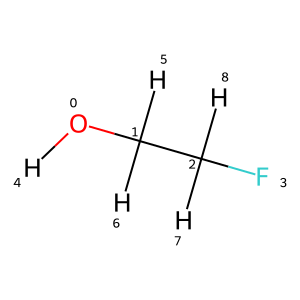

In [28]:
mol_wH

In [29]:
bounds = rdDistGeom.GetMoleculeBoundsMatrix(mol_wH)
print(bounds[0,3],bounds[3,0])
print(bounds)

3.577721455918935 2.4404633316754305
[[0.         1.40384485 2.41567928 3.57772146 1.0002542  2.09083554
  2.09083554 3.32995995 3.32995995]
 [1.38384485 0.         1.524      2.40583747 2.00083855 1.11940079
  1.11940079 2.19506659 2.19506659]
 [2.33567928 1.504      0.         1.39151956 3.24721822 2.19506659
  2.19506659 1.11940079 1.11940079]
 [2.44046333 2.32583747 1.37151956 0.         4.40667602 3.31882822
  3.31882822 2.08024276 2.08024276]
 [0.9802542  1.92083855 2.28378463 1.89       0.         2.88187238
  2.88187238 4.19590515 4.19590515]
 [2.01083554 1.09940079 2.11506659 2.35947104 2.09773285 0.
  1.85196558 3.075381   3.075381  ]
 [2.01083554 1.09940079 2.11506659 2.35947104 2.09773285 1.77196558
  0.         3.075381   3.075381  ]
 [2.36485007 2.11506659 1.09940079 2.00024276 1.68       2.25465119
  2.25465119 0.         1.85196558]
 [2.36485007 2.11506659 1.09940079 2.00024276 1.68       2.25465119
  2.25465119 1.77196558 0.        ]]


paper [link](https://pubs.acs.org/doi/pdf/10.1021/acs.jcim.5b00654)
[drugbank](https://go.drugbank.com/drugs/DB01001)

Text(0.5, 0, 'O--F distance')

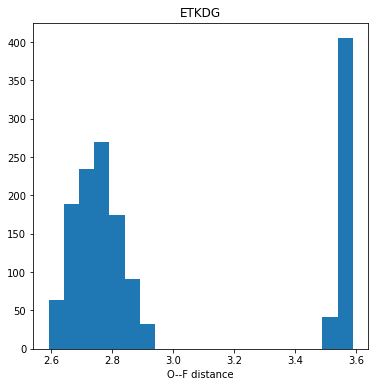

In [30]:

ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
ps.SetBoundsMat(bounds)

# ps = rdDistGeom.EmbedParameters()
# ps.useExpTorsionAnglePrefs = False

ps.useBasicKnowledge = False
cids = rdDistGeom.EmbedMultipleConfs(mol_wH,1500,ps)
dists_etkdg = [rdMolTransforms.GetBondLength(conf,0,3) for conf in mol_wH.GetConformers()]

plt.figure(figsize = (6, 6))
plt.hist(dists_etkdg, bins=20)
plt.title('ETKDG')
plt.xlabel('O--F distance')


In [31]:
# draw a single conformer with RDKit
IPythonConsole.drawMol3D(mol_wH,confId=cids[2])


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [32]:
# draw a single conformer with py3MOL

conf0 = Chem.MolToMolBlock(mol_wH, confId=cids[2])
print(conf0)
xyzview = py3Dmol.view(width=400, height=400)
xyzview.addModel(conf0, 'sdf')
xyzview.setStyle({'sphere': {'radius': 0.35}, 'stick': {'radius': 0.1}})
xyzview.setBackgroundColor('0xeeeeee')
xyzview.zoomTo()
xyzview.show()



     RDKit          3D

  9  8  0  0  0  0  0  0  0  0999 V2000
   -1.5259    0.4230    0.0433 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5046   -0.4990   -0.0933 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.8656    0.1087    0.0872 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.1203    1.1025   -0.8321 F   0  0  0  0  0  0  0  0  0  0  0  0
   -1.2571    1.3601   -0.0417 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5982   -1.2247    0.7636 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6130   -1.0805   -1.0155 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.9138    0.5320    1.1052 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.5990   -0.7221   -0.0168 H   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  0
  1  5  1  0
  2  6  1  0
  2  7  1  0
  3  8  1  0
  3  9  1  0
M  END



You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [34]:
conf0 = Chem.MolToMolBlock(mol_wH, confId=cids[100])
conf1 = Chem.MolToMolBlock(mol_wH, confId=cids[0])

xyzview = py3Dmol.view(width=400, height=400)
for i in range(10):
    conf0 = Chem.MolToMolBlock(mol_wH, confId=cids[i])
    print(conf0)
    xyzview.addModel(conf0, 'sdf')
# xyzview.addModel(conf1, 'sdf')
# xyzview.setStyle({'sphere': {'radius': 0.35}, 'stick': {'radius': 0.1}})
xyzview.setStyle({'stick':{'radius': 0.05}})
xyzview.setBackgroundColor('0xeeeeee')
xyzview.zoomTo()
xyzview.show()


     RDKit          3D

  9  8  0  0  0  0  0  0  0  0999 V2000
   -1.2581    0.9342    0.0615 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6411   -0.3337    0.0845 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.8688   -0.1078    0.1480 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.3088    0.6060   -0.9502 F   0  0  0  0  0  0  0  0  0  0  0  0
   -0.8220    1.3944   -0.7089 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.9972   -0.8798    0.9786 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.9344   -0.9013   -0.7989 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.1129    0.4052    1.0877 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.3624   -1.1171    0.0977 H   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  0
  1  5  1  0
  2  6  1  0
  2  7  1  0
  3  8  1  0
  3  9  1  0
M  END


     RDKit          3D

  9  8  0  0  0  0  0  0  0  0999 V2000
   -1.2807    0.8278    0.0709 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6282   -0.4216    0.0540 C   0  0  0  0  0  0  0  0 

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Extra references:
1. https://pubs.rsc.org/en/content/articlehtml/2022/sc/d2sc02739a?page=search
2. https://github.com/atomistic-machine-learning/schnetpack
3. https://doi.org/10.1186/s13321-018-0258-y